# Grupo

- Luan Issegue
- Lucas Bottino
- Nícolas Mikio

In [1]:
#Importa as bibliotecas
import yfinance as yf
import math
import matplotlib.pyplot as plt
import numpy as np
from time import time
import pandas as pd
from datetime import date
plt.style.use('dark_background')
%load_ext autoreload
%autoreload 2
%matplotlib inline

O código e parte das funções foram desenvolvidas pelo grupo, mas a maoria das funções foram extraídas do curso Introduction to Portfolio Construction and Analysis with Python da EDHEC Business School ministrada no Coursera, curso que Nícolas Mikio assistiu.

In [2]:
def consulta_bc(codigo_bcb):
    '''
    Importa os dados Banco Central através de uma API
    '''
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df


def calcula_retornos(data: pd.Series, column="Close"):
    '''
    Calcula o retorno acumulado da série
    '''
    df = data[column].pct_change()
    df.drop(df.head(1).index,inplace=True)
    
    return pd.DataFrame(df)

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol



def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5


def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")


from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x


def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)


def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights


def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend)
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=1, markersize=6)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        
        return ax


In [3]:
#Importa os dados do Yahoo Finance
data = yf.download("ITSA4.SA PETR4.SA BRML3.SA PSSA3.SA", start="2018-01-01", interval = "1d")
display(data)

[*********************100%***********************]  4 of 4 completed


Adj Close                                     Close             \
             BRML3.SA   ITSA4.SA   PETR4.SA   PSSA3.SA BRML3.SA   ITSA4.SA   
Date                                                                         
2018-01-02  11.446580   8.269901  14.853566  29.075911    12.40  10.027272   
2018-01-03  11.409657   8.367372  14.988194  29.603111    12.36  10.145454   
2018-01-04  11.548123   8.524822  15.015120  29.627069    12.51  10.336363   
2018-01-05  11.585049   8.539814  15.104866  30.202202    12.55  10.354545   
2018-01-08  11.538891   8.532317  15.284368  30.050434    12.50  10.345454   
...               ...        ...        ...        ...      ...        ...   
2021-05-19  10.670000  10.740000  26.150000  51.750000    10.67  10.740000   
2021-05-20  11.080000  10.780000  25.930000  51.580002    11.08  10.780000   
2021-05-21  10.850000  10.840000  25.950001  50.750000    10.85  10.840000   
2021-05-24  10.830000  10.860000  26.389999  50.930000    10.83  10.860000   
2021-05-25  10.850000  10.860000  25.840000  51.410000    10.85  10.860000   

                                     High             ...        Low  \
             PETR4.SA   PSSA3.SA BRML3.SA   ITSA4.SA  ...   PETR4.SA   
Date                                                  ...              
2018-01-02  16.549999  36.400002    12.78  10.027272  ...  16.190001   
2018-01-03  16.700001  37.060001    12.47  10.181818  ...  16.370001   
2018-01-04  16.730000  37.090000    12.64  10.363636  ...  16.620001   
2018-01-05  16.830000  37.810001    12.66  10.354545  ...  16.570000   
2018-01-08  17.030001  37.619999    12.60  10.345454  ...  16.709999   
...               ...        ...      ...        ...  ...        ...   
2021-05-19  26.150000  51.750000    10.85  10.740000  ...  25.799999   
2021-05-20  25.930000  51.580002    11.14  10.890000  ...  25.719999   
2021-05-21  25.950001  50.750000    11.15  10.850000  ...  25.940001   
2021-05-24  26.389999  50.930000    10.94  10.900000  ...  25.990000   
2021-05-25  25.840000  51.410000    11.02  10.880000  ...  25.780001   

                          Open                                     Volume  \
             PSSA3.SA BRML3.SA   ITSA4.SA   PETR4.SA   PSSA3.SA  BRML3.SA   
Date                                                                        
2018-01-02  36.169998    12.65   9.881818  16.190001  36.330002   7511700   
2018-01-03  36.500000    12.38   9.981818  16.490000  36.650002   4013900   
2018-01-04  36.840000    12.41  10.172727  16.780001  37.310001   7953200   
2018-01-05  37.020000    12.59  10.336363  16.700001  37.349998   3221100   
2018-01-08  37.419998    12.55  10.300000  16.740000  37.910000   3047500   
...               ...      ...        ...        ...        ...       ...   
2021-05-19  51.040001    10.60  10.540000  25.850000  51.209999  14196900   
2021-05-20  51.150002    10.71  10.740000  26.150000  51.730000  23167900   
2021-05-21  50.250000    11.15  10.790000  26.080000  51.580002  12542500   
2021-05-24  50.610001    10.89  10.860000  26.280001  50.959999  17351000   
2021-05-25  50.910000    10.90  10.850000  26.480000  51.189999  11562000   

                                         
            ITSA4.SA  PETR4.SA PSSA3.SA  
Date                                     
2018-01-02  14040950  33461800   218000  
2018-01-03  13498870  55940900   234000  
2018-01-04  14303520  37064900   274000  
2018-01-05  10845010  26958200   384100  
2018-01-08  11024750  28400000   290600  
...              ...       ...      ...  
2021-05-19  21080600  84700500   659200  
2021-05-20  28326800  71371100   553200  
2021-05-21  18604600  82884500  1017300  
2021-05-24  26485900  63029600   465100  
2021-05-25  29182500  63206400   714200  

[835 rows x 24 columns]

In [4]:
#Calcula os retornos das série
x = calcula_retornos(data)
x

,BRML3.SA,ITSA4.SA,PETR4.SA,PSSA3.SA
Date,,,,
2018-01-03,-0.003226,0.011786,0.009064,0.018132
2018-01-04,0.012136,0.018817,0.001796,0.000809
2018-01-05,0.003197,0.001759,0.005977,0.019412
2018-01-08,-0.003984,-0.000878,0.011884,-0.005025
2018-01-09,-0.019200,-0.015817,0.000000,0.006911
...,...,...,...,...
2021-05-19,-0.007442,0.011299,-0.007590,0.004464
2021-05-20,0.038425,0.003724,-0.008413,-0.003285
2021-05-21,-0.020758,0.005566,0.000771,-0.016092


In [5]:
x.std()

BRML3.SA    0.028995
ITSA4.SA    0.021736
PETR4.SA    0.033400
PSSA3.SA    0.020546
dtype: float64

In [6]:
#Calcula os retornos anualizados
xano = annualize_rets(x, 252)
xano

BRML3.SA   -0.039544
ITSA4.SA    0.024398
PETR4.SA    0.144105
PSSA3.SA    0.109960
dtype: float64

In [7]:
#Calcula a matriz de covariância anualizada
cov = x.cov()*252
cov

,BRML3.SA,ITSA4.SA,PETR4.SA,PSSA3.SA
BRML3.SA,0.211858,0.094470,0.126769,0.053892
ITSA4.SA,0.094470,0.119056,0.111333,0.044559
PETR4.SA,0.126769,0.111333,0.281129,0.054148
PSSA3.SA,0.053892,0.044559,0.054148,0.106379


In [8]:
#Calcula a Taxa Livre de Risco
cdi = consulta_bc(12)
cdi_recente = cdi.iloc[-1]
r = (1 + cdi_recente/100).prod()**(252)-1
r

0.034000915787165464

## Minimizando a volatilidade para dado retorno

In [9]:
# Pesos para um portfolio com 7% de retorno esperado, minimizando a volatilidade
array2 = minimize_vol(0.070, xano, cov).round(2)
df = pd.DataFrame(array2)
df.index = xano.index
df = df.rename(columns={0: "Pesos"})
df

,Pesos
BRML3.SA,0.03
ITSA4.SA,0.42
PETR4.SA,0.00
PSSA3.SA,0.55


In [10]:
print("Portfolio return:", portfolio_return(array2, xano).round(2))
print("Portfolio volatility:", portfolio_vol(array2, cov).round(2))

Portfolio return: 0.07
Portfolio volatility: 0.28


## Global Minimum Variance Portfolio

In [11]:
gmv2 = gmv(cov)
pesos = pd.DataFrame(gmv2)
pesos.index = xano.index
pesos = pesos.rename(columns={0: "Pesos"})
pesos

,Pesos
BRML3.SA,0.045211
ITSA4.SA,0.419528
PETR4.SA,0.000000
PSSA3.SA,0.535261


In [12]:
print("Global Minimum Variance return:", portfolio_return(gmv2, xano).round(2))
print("Global Minimum Variance volatility:", portfolio_vol(gmv2, cov).round(2))

Global Minimum Variance return: 0.07
Global Minimum Variance volatility: 0.28


## Maximum Sharpe Portfolio

In [13]:
# Pesos do Maximum Sharpe Portfolio
array = msr(r, xano, cov).round(2)
msrpesos = pd.DataFrame(array)
msrpesos.index = xano.index
msrpesos = msrpesos.rename(columns={0: "Pesos"})
msrpesos

,Pesos
BRML3.SA,0.00
ITSA4.SA,0.00
PETR4.SA,0.33
PSSA3.SA,0.67


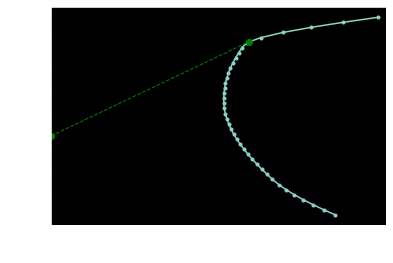

In [14]:
#Plota a fronteira de Markowitz e o Capital Market Line
plot_ef(40, xano, cov, show_cml=True, riskfree_rate = r)

In [15]:
print("Maximum Sharpe Portfolio return:", portfolio_return(array, xano).round(2))
print("Maximum Sharpe Portfolio volatility:", portfolio_vol(array, cov).round(2))

Maximum Sharpe Portfolio return: 0.12
Maximum Sharpe Portfolio volatility: 0.32


## Equally Weighted Portfolio

In [16]:
w = np.array([.25, 0.25, 0.25, 0.25])

print("Equally Weighted Portfolio return:", portfolio_return(w, xano).round(2))
print("Equally Weighted Portfolio volatility:", portfolio_vol(w, cov).round(2))

Equally Weighted Portfolio return: 0.06
Equally Weighted Portfolio volatility: 0.32
